<a href="https://colab.research.google.com/github/kan-va/lab_vision_digits/blob/main/Task_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лаборатоная работа по распознаванию рукописных цифр 


In [4]:
print("Hello student")  # для запуска блока с кодом нажмите кобинацию клавиш shift + enter, 
                        # либо на треугольник, при наведении в левом верхнем углу блока кода 

Hello student


## Содержание:


1.   Введение
2.   Основные определения / полезные материалы
3.   Разведочный анализ данных (EDA)
4.   Подготовка датасета
5.   Создание и обучение нейросети
6.   Апробация результатов

## Введение



В данной работе научимся создавать многослойные нейронные сети для распознавания рукописных цифр.

MNIST - это набор данных, разработанный Янн ЛеКун, Коринной Кортес и Кристофером Берджесом для оценки моделей машинного обучения по задаче классификации рукописных цифр. Набор данных был составлен из нескольких наборов данных отсканированных документов, доступных из Национальный институт стандартов и технологий(NIST). Отсюда и название набора данных, например, модифицированный набор данных NIST или MNIST.

официальный сайт http://yann.lecun.com/exdb/mnist/ где выложен дата сет MNIST, а так  представлены результаты обучаемых моделей.


### Параметры датасета:
Изображения цифр были взяты из различных отсканированных документов, нормализованы по размеру и центрированы. Это делает его отличным набором данных для оценки моделей, позволяя разработчику сосредоточиться на машинном обучении с минимальной очисткой или подготовкой данных.

Каждое изображение представляет собой квадрат 28 x 28 пикселей. Стандартный набор данных используется для оценки и сравнения моделей, где 60 000 изображений используются для обучения модели, а отдельный набор из 10 000 изображений используется для ее проверки.

## Основные определения / полезные материаллы


#### Определения 

1. Batch - на маленькие партии из датасета
2. Batch Size - Общее число тренировочных объектов, представленных в одном батче.
3. Произошла одна эпоха (epoch) — весь датасет прошел через нейронную сеть в прямом и обратном направлении только один раз.
4. Loss - "лосс" называют функцию потерь 
5. Итерации — число батчей, необходимых для завершения одной эпохи.


#### Дополнительные материалы

1.   [Описание работы с полносвязным слоем в keras ](https://habr.com/ru/post/482126/)
2.   [Инструкция](https://colab.research.google.com/drive/1gQRDXVm4GFKJPhXfCp6uxoJ8FAHklstx#scrollTo=4x1VwqYcyxr7&line=1&uniqifier=1) подгрузки библиотек, которые не являются предустановленными в colab.google


```
# !pip install pillow 
```


3. 



## Библиотеки необходимы для сосздания нейронной сети.

In [5]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.datasets import mnist         # библиотека базы Mnist
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.utils import np_utils
import matplotlib.pyplot as plt # библиотка для визуализации данных
import seaborn as sns # другая библиотка для визуализации данных
# import pandas as pd
import numpy as np # библиотека позволяющая работать с векторами и матрицами
import random as rand
from pprint import pprint




## Разведочный анализ данных (EDA)

Подгрузим датасет mnist из библиотеки keras и убедимся что там лежит. 

x_train[i] - двумерный вектор изображения, 

y_train[i] - таргет, т.е. значение 0 - 9, соответсвующая цифре на изображении. 

(x_test, y_test) имеют аналогичную структуру.

11493376/11490434 [==============================] - 0s 0us/step
number image
[(17153, 2), (47093, 8), (10543, 5), (49764, 9), (20196, 9), (46301, 9),
 (19607, 5), (35759, 4), (47906, 7), (38705, 7), (47386, 0), (35829, 1),
 (32775, 3), (26215, 9), (32505, 3), (46624, 4), (1427, 2), (53695, 5),
 (39719, 2), (13864, 4)]


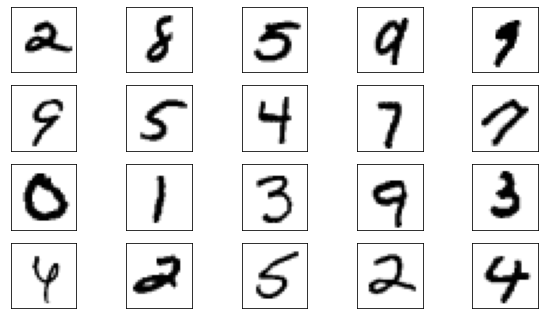

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() 
len(mnist.load_data())
index = [rand.randint(0, 60000) for i in range(20)] # выберем случайный образом 4 индекса
print("number image")
pprint([(i, y_train[i])for i in index], compact=True) # выводим красиво значения индекса и y_train

# отображение первых 20 изображений из обучающей выборки
plt.figure(figsize=(10,7))
for i in range(len(index)):
    plt.subplot(5,5,i+1)
    plt.xticks([]) # убрать отрисовку оси Х
    plt.yticks([]) # убрать отрисовку оси У
    plt.imshow(x_train[index[i]], cmap=plt.cm.binary) # cmap=plt.get_cmap('gray') - позволяет вывести в градиенте серого
plt.show()



Проверяем распределение чисел в тенеровочной и валидационной выборке

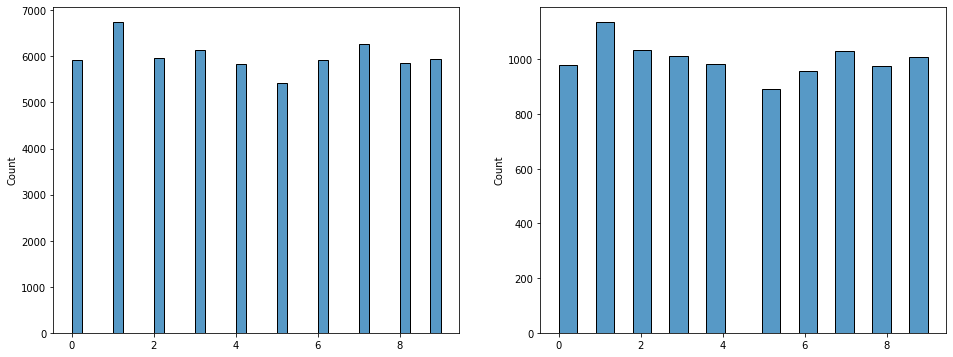

In [7]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.histplot(y_train, kde=False ) # гистограмма тренировочной выборки
plt.subplot(1,2,2)
sns.histplot(y_test, kde=False) # гистограмма валидационной выборки

## Подготовка датасета

**Подготовка выходных значений**

Для полносвязного персептрона входные данные необходимо представить в виде вектора, поэтому представим изобрадение как одномерный массив из 28*28 = 784 элементов


In [8]:
# преобразование изображение 28 х 28 в виде одномерного вектора
num_pixels = x_train.shape[1] * x_train.shape[2] # получем размерность по вертикали и горизонтали
x_train = x_train.reshape(x_train.shape[0], num_pixels).astype('float32') 
x_test = x_test.reshape(x_test.shape[0], num_pixels).astype('float32')

# нормализуем значения 0 - 255 в 0 - 1
x_train = x_train / 255
x_test = x_test / 255

**Подготовка выходных значений**

Выходной переменной является целое число от 0 до 9. Это проблема классификации нескольких классов. Таким образом, эффективная практика состоит в том, чтобы использовать горячее кодирование значений класса, преобразовывая вектор целых чисел класса в двоичную матрицу, где каждое значение y_train, y_test представляется как вектор где на i-й позиции, которая сооствует значению цифры на изображении, ставится 1.


Используем встроенную вспомогательную функцию np_utils.to_categorical () в Keras.

In [9]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [10]:
print(y_test.shape)
y_test

(10000, 10)


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Создание и обучение нейросети


### Полносвязный персептрон

Модель представляет собой простую нейронную сеть с одним скрытым слоем с тем же количеством нейронов, что и у входов (784). Функция активации выпрямителя используется для нейронов в скрытом слое.

Функция активации softmax используется на выходном слое для преобразования выходных значений в вероятностные значения и позволяет выбрать один класс из 10 в качестве выходного прогнозирования модели. Логарифмическая потеря используется как функция потерь (так называемая категориальная_кросентропия в Керасе), а эффективный алгоритм градиентного спуска ADAM используется для определения весов.

Теперь мы можем подобрать и оценить модель. Модель подходит для 10 эпох с обновлениями каждые 200 изображений. Тестовые данные используются в качестве набора данных для проверки, что позволяет увидеть навыки модели во время ее обучения. Подробное значение 2 используется для уменьшения вывода до одной строки для каждой эпохи обучения.



In [11]:
# model = keras.Sequential([
#     Flatten(input_shape=(28, 28, 1)), # входной слой / преобрахование картинки в одномерный вектор
#     Dense(128, activation='relu'),    # добавление скрытого полносвязного слоя со 128 нейоранами
#     Dense(10, activation='softmax')   # # добавление полносвязного слоя выхода
# ])
# print(model.summary())


In [12]:
# функция основной модели нейронной сети
def baseline_model():
  # создание модели
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_pixels, input_dim=128, kernel_initializer='normal', activation='sigmoid'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# # заполнение модели / выбор функция качества (потерь), метод оптимизациии, метрика
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model


Теперь мы можем обучим и оценим качество обученности модели.

In [18]:
# создаем модель
model = baseline_model()
print(model.summary()) # просматриваем структурау модели (сколько обучаемых параметров на каждом слое и сколько скрытых слоев)

# обучаем модель
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=200, verbose=2)

# оценка модели в процентах
scores = model.evaluate(x_test, y_test, verbose=0)
print()
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_7 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                7850      
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
300/300 - 9s - loss: 0.2820 - accuracy: 0.9179 - val_loss: 0.1287 - val_accuracy: 0.9605
Epoch 2/10
300/300 - 9s - loss: 0.0966 - accuracy: 0.9717 - val_loss: 0.0882 - val_accuracy: 0.9728
Epoch 3/10
300/300 - 9s - loss: 0.0592 - accuracy: 0.9819 - val_loss: 0.0684 - val_accuracy: 0.9782
Epoch 4/10
300/300 - 9s - loss: 0.0409 - accuracy: 0.9875 - val_loss:

In [14]:
## Проверка влияния кол-ва эпох и размеров батчей на точнось нейросети

# model_1 = baseline_model()
# model_1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=728, verbose=2)
# scores = model.evaluate(x_test, y_test, verbose=0)
# print("Baseline Error: %.2f%%" % (100-scores[1]*100))

# Апробация результатов

Ручная проверка: выбираем одино изображение из тестового множества, выводим его на его на экран, затем по дставлем его в обученную нейросеть и смотрим результаты предсказания.

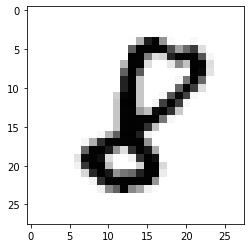

In [28]:
# демонстрация выборочного изображения

number = rand.randint(0, 10000) # под каким индексом берем изображение
plt.imshow(x_test[number].reshape((28, 28)), cmap="Greys")
plt.show()

In [29]:
img = np.expand_dims(x_test[number], axis=0)
res = model.predict(img)
print("это скорее всего цифра: " + str(np.argmax(res)) + ", с вероятностью: " + str(max(*res)))

это скорее всего цифра: 8, с вероятностью: 1.0
